# import

In [82]:
import pandas as pd, numpy as np, re, scipy.stats as stats
import seaborn as sns, matplotlib.pyplot as plt, plotly.express as px
from collections import Counter
from tqdm import tqdm


from sklearn import decomposition
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler


from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectPercentile
from mlxtend.feature_selection import SequentialFeatureSelector


import warnings
warnings.filterwarnings('ignore')

# 1. Датасет

In [2]:
%%time
'''
Функция для предварительной обработки датасета:
1) Заполнение пустых значений в поле "Employment.Type"
2) Удаление столбцов с ID
3) Перевод столбцов в датами в формат дат
4) LabelEncoding
'''

df_pr = pd.read_csv('train_LTFS.csv')

def preprocess_df(df):
    print('Start...')
    df['Employment.Type'].fillna('Salaried', inplace=True)
    df.drop_duplicates(inplace=True)
    df.drop(['MobileNo_Avl_Flag', 'PRI.CURRENT.BALANCE'], axis=1, inplace=True)
    
    drops = [col for ind, col in enumerate(df.columns) if re.search('id', col.lower())]
    df.drop(drops, axis=1, inplace=True)

    
    print('Find dates...')
    df['AVERAGE.ACCT.AGE'] = [int(re.findall('[0-9]+', len_hist)[0])*12 + int(re.findall('[0-9]+', len_hist)[1]) 
                              for len_hist in df['AVERAGE.ACCT.AGE']]
    
    df['CREDIT.HISTORY.LENGTH'] = [int(re.findall('[0-9]+', len_hist)[0])*12 + int(re.findall('[0-9]+', len_hist)[1]) 
                              for len_hist in df['CREDIT.HISTORY.LENGTH']]
    
    print('To datetime...')
    df['Date.of.Birth'] = pd.to_datetime(df['Date.of.Birth'], errors='coerce').dt.year
    df['Date.of.Birth'] = df['Date.of.Birth'].apply(lambda x: x - 100 if x >= 2005 else x)
    
    df['DisbursalDate'] = pd.to_datetime(df['DisbursalDate'], errors='coerce')
    df['Disbursal_day'] = df['DisbursalDate'].dt.day
    df['Disbursal_day_week'] = df['DisbursalDate'].dt.dayofweek
    df['Disbursal_month'] = df['DisbursalDate'].dt.month
    df.drop('DisbursalDate', axis=1, inplace=True)
    
    print('Label Encoder...')
    df['Employment.Type'] = LabelEncoder().fit_transform(df['Employment.Type'])
    df['PERFORM_CNS.SCORE.DESCRIPTION'] = LabelEncoder().fit_transform(df['PERFORM_CNS.SCORE.DESCRIPTION'])
    
    df.dropna(axis=0, inplace=True)
    print('End!')
    
    return df

df = preprocess_df(df_pr)
print()

Start...
Find dates...
To datetime...
Label Encoder...
End!

CPU times: total: 15.3 s
Wall time: 15.6 s


In [3]:
# Удаляем выбросы с помощью Z-score
df_pr = pd.read_csv('train_LTFS.csv')

z = np.abs(stats.zscore(df))
data_clean = df[(z < 3).all(axis=1)]

print(f'размерность оригинального датасета {df_pr.shape}')
print(f'размерность после предобработки {data_clean.shape}')

data_clean.head()

размерность оригинального датасета (233154, 41)
размерность после предобработки (174993, 33)


,disbursed_amount,asset_cost,ltv,Date.of.Birth,Employment.Type,Aadhar_flag,PAN_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,...,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,Disbursal_day,Disbursal_day_week,Disbursal_month
1,47145,65550,73.23,1985,1,1,0,0,0,598,...,0,0,1,23,23,0,1,26,2,9
3,57513,66113,88.48,1993,1,1,0,0,0,305,...,0,0,0,8,15,1,1,26,4,10
4,52378,60300,88.39,1977,1,1,0,0,0,0,...,0,0,0,0,0,1,1,26,2,9
5,54513,61900,89.66,1990,1,1,0,0,0,825,...,0,0,0,21,24,0,0,19,2,9
6,46349,61500,76.42,1988,0,1,0,0,0,0,...,0,0,0,0,0,0,0,23,6,9


In [4]:
%%time

'Определим переменные, которые сильнее всего влияют на loan_default и их оптимальное количество'

y = data_clean.loan_default
x = data_clean.drop('loan_default', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.25)


log = Pipeline(steps=[('sc', MinMaxScaler()),
                              ('sl', SelectKBest(score_func=chi2, k=2)),
                              ('model', LogisticRegression())])

log.fit(x_train, y_train)
                       
param_grid = {'sl__k': [8, 10, 12, 14, 16, 18, 20, 22, 24, 26]}     
                
search_log = GridSearchCV(log, 
                             param_grid, 
                             cv=5, 
                             n_jobs=-1, 
                             scoring='roc_auc', 
                             refit=True, 
                             verbose=10)
                
search_log.fit(x_train, y_train)

print()
print(f'Оптимальное количество параметров - {search_log.best_estimator_[1]}')
print()

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Оптимальное количество параметров - SelectKBest(k=22, score_func=<function chi2 at 0x000001B1E774D820>)

CPU times: total: 3.77 s
Wall time: 13.8 s


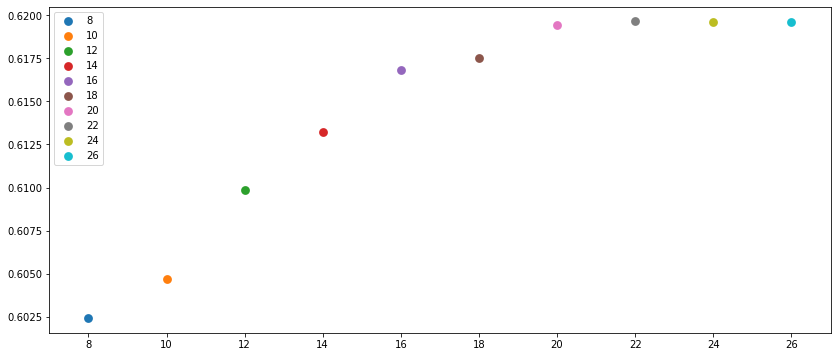

In [5]:
plt.subplots(figsize=(14, 6))

sns.pointplot(x=search_log.cv_results_['param_sl__k'], 
              y=search_log.cv_results_['mean_test_score'],
             hue=search_log.cv_results_['param_sl__k'])
plt.show()

In [110]:
# выбранные колонки
select = SelectKBest(score_func=chi2, k=20)
best = select.fit_transform(x, y)

columns_imp=x.columns[select.get_support()].to_list()
columns_imp

['disbursed_amount',
 'asset_cost',
 'ltv',
 'Employment.Type',
 'Aadhar_flag',
 'PERFORM_CNS.SCORE',
 'PERFORM_CNS.SCORE.DESCRIPTION',
 'PRI.NO.OF.ACCTS',
 'PRI.ACTIVE.ACCTS',
 'PRI.OVERDUE.ACCTS',
 'PRI.SANCTIONED.AMOUNT',
 'PRI.DISBURSED.AMOUNT',
 'PRIMARY.INSTAL.AMT',
 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
 'AVERAGE.ACCT.AGE',
 'CREDIT.HISTORY.LENGTH',
 'NO.OF_INQUIRIES',
 'Disbursal_day',
 'Disbursal_day_week']

In [7]:
# нормируем данные

for ind, val in enumerate(data_clean[columns_imp]):
    data_clean[val] = np.log1p(data_clean[val])

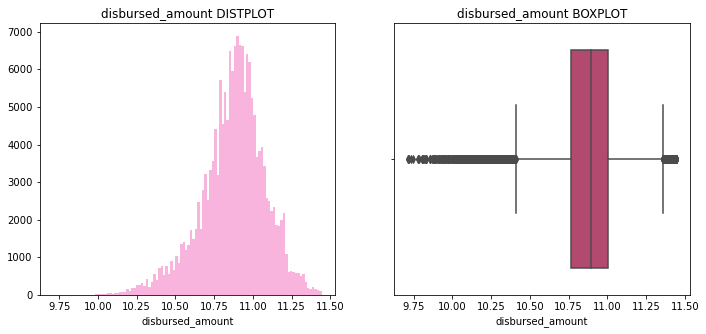

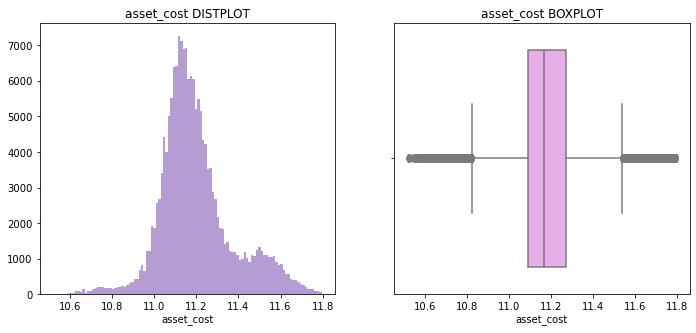

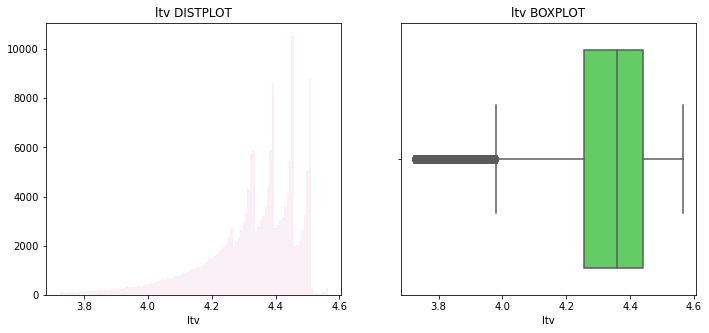

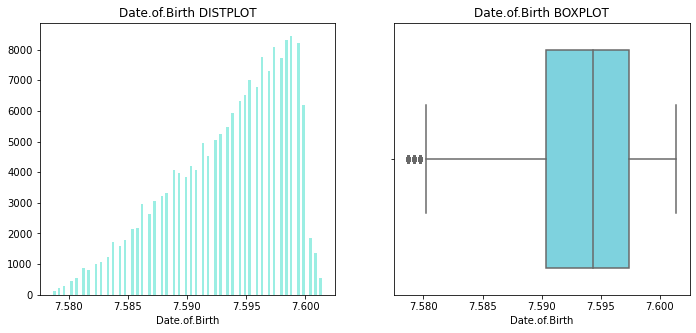

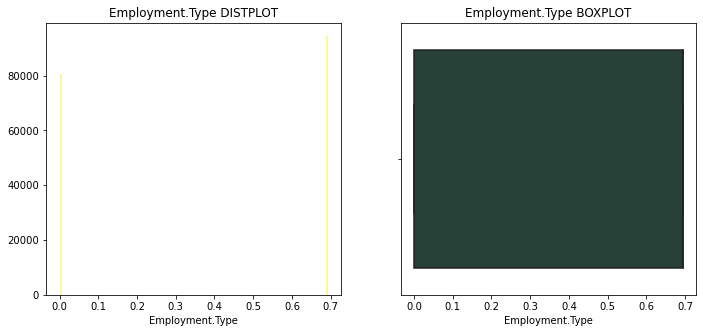

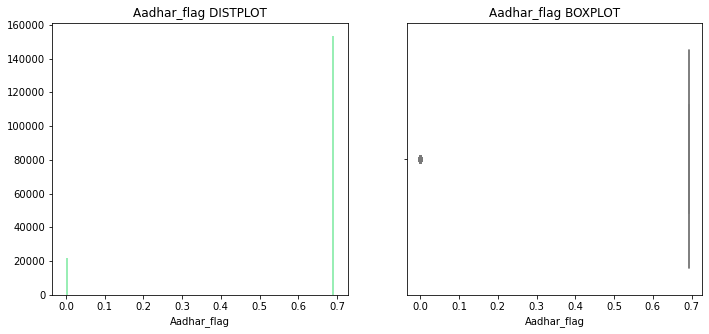

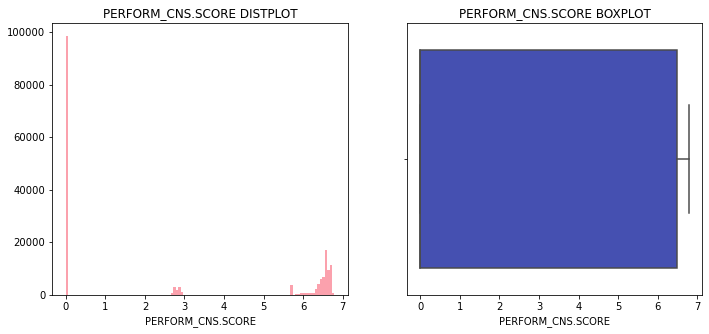

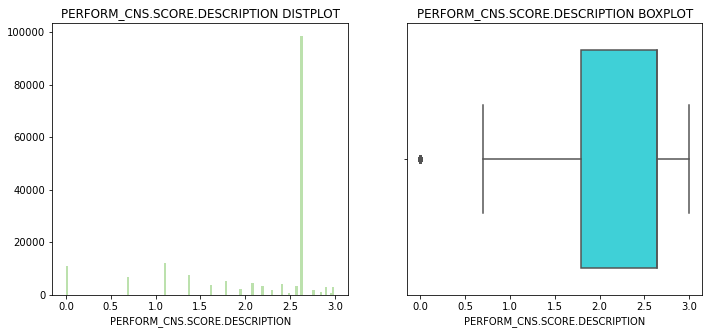

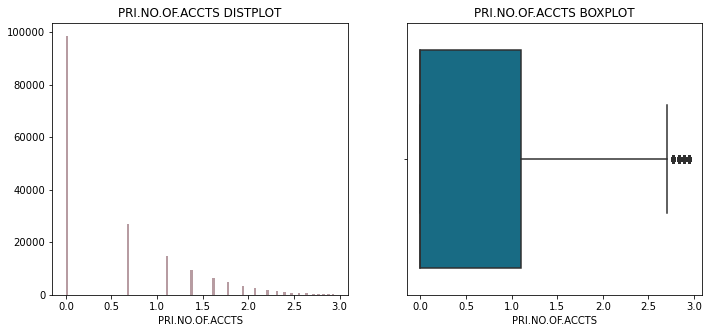

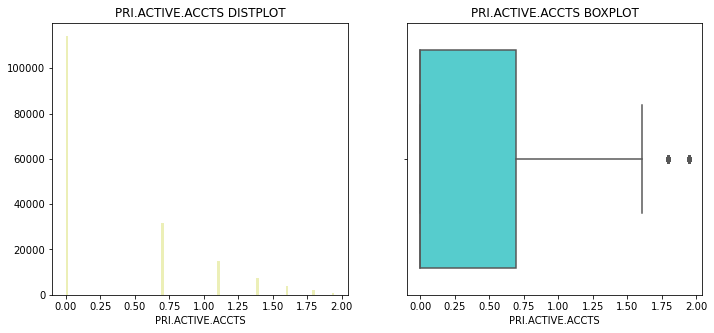

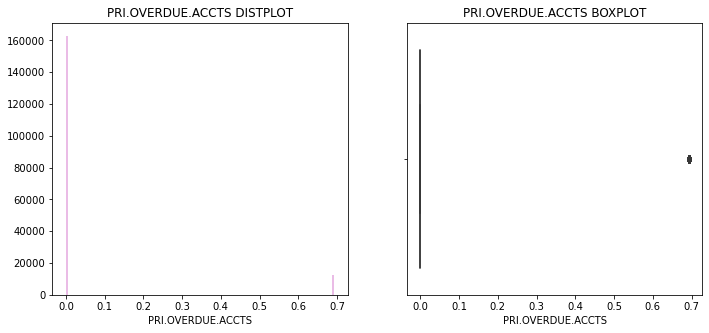

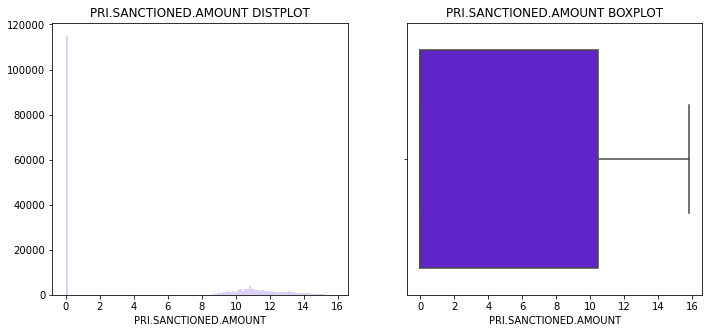

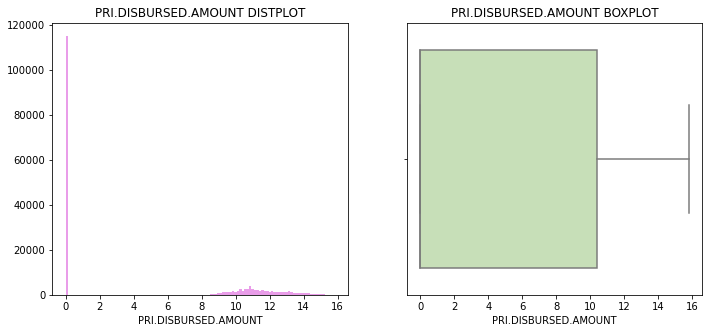

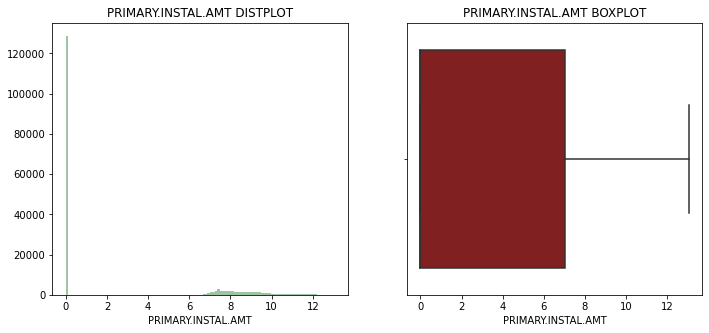

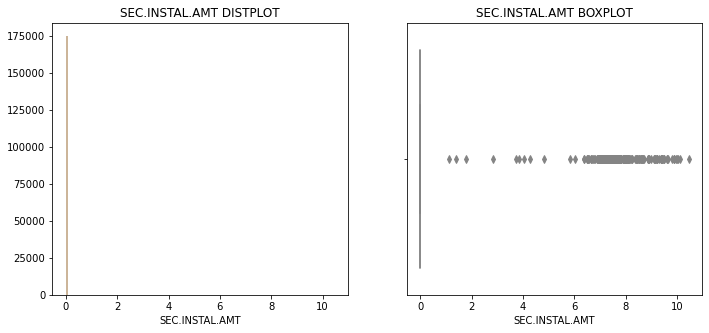

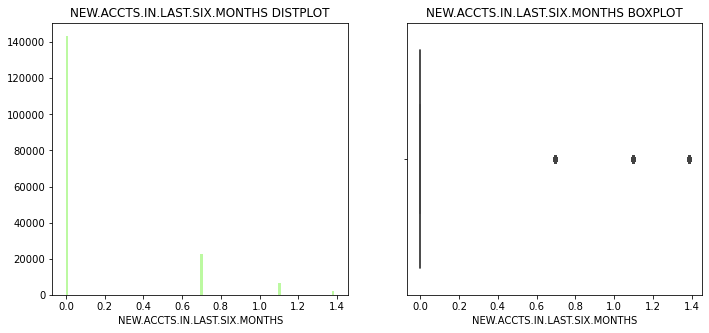

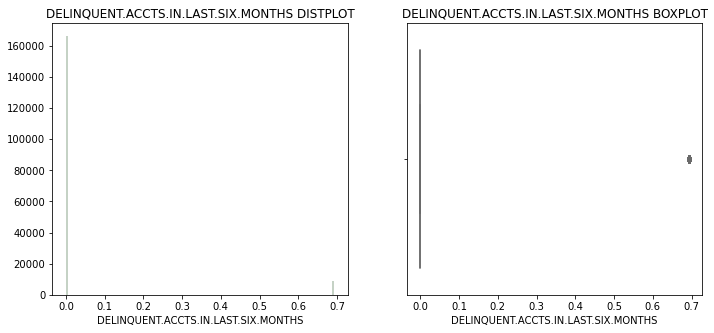

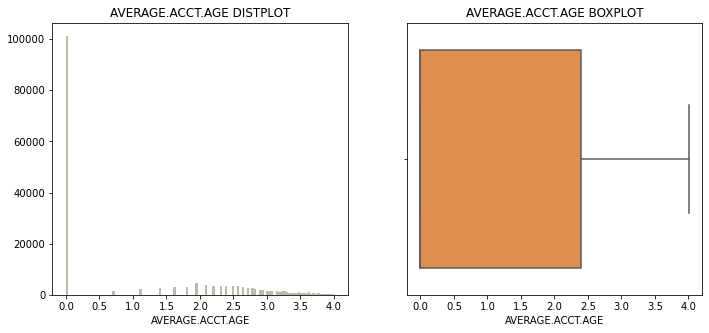

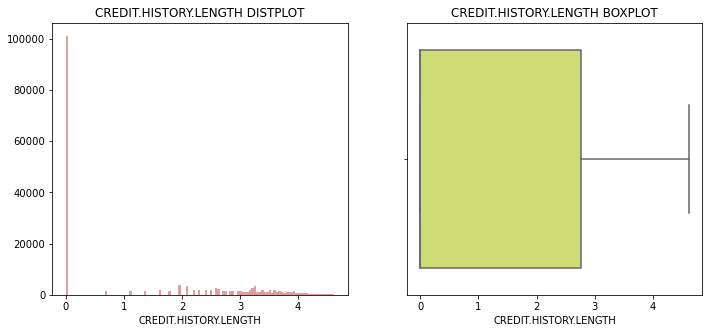

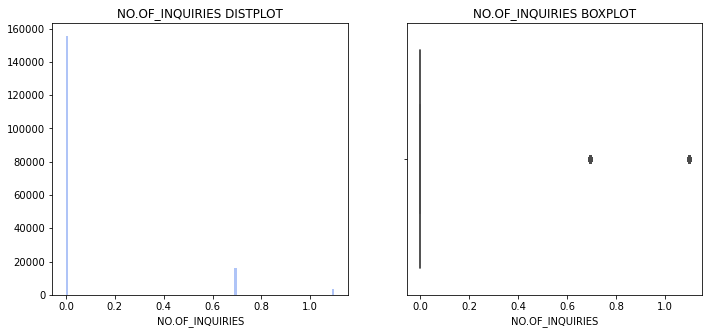

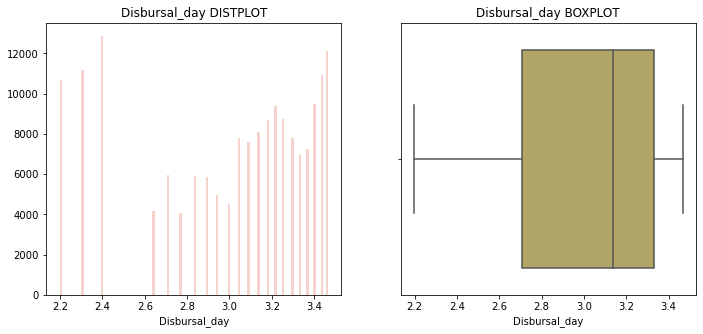

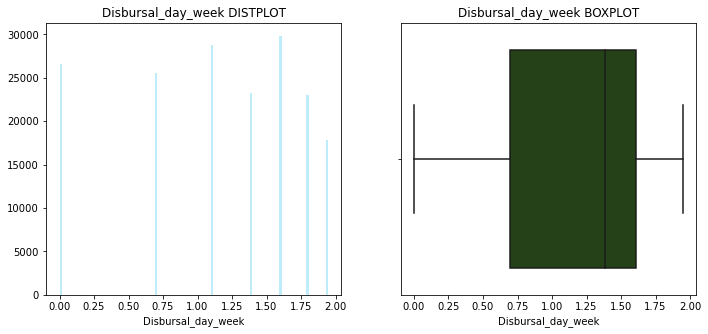

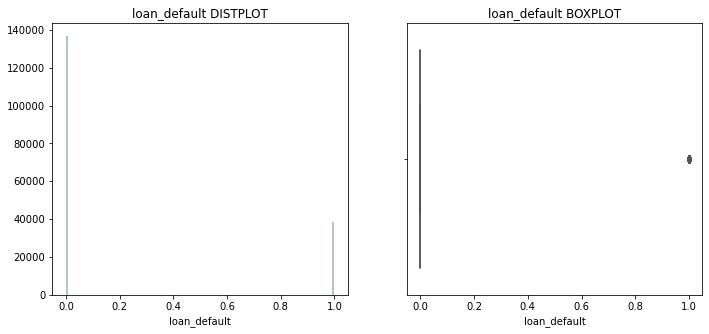

In [8]:
plt.rcParams['figure.figsize'] = (18, 5)

for col in data_clean[columns_imp+['loan_default']].columns:
    plt.subplot(1, 3, 1)
    sns.distplot((data_clean[col]), bins=110, 
                 color = (np.random.random(), np.random.random(), np.random.random()), kde=False)
    plt.title(f'{col} DISTPLOT')

    plt.subplot(1, 3, 2)
    sns.boxplot((data_clean[col]), color = (np.random.random(), np.random.random(), np.random.random()))
    plt.title(f'{col} BOXPLOT')
    plt.show()

In [97]:
'''
Также была реализация выделения важных признаков с помощью RandomForestClassifier, 
но SelectKBest показало лучшие результаты
'''

# importances = forest.feature_importances_
# std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

# forest_importances = pd.Series(importances, index=x.columns.to_list())
# colors = []
# columns_imp = []
# for ind, imp in enumerate(forest_importances):
#     if imp >=0.04:
#         colors.append('green')
#         columns_imp.append(forest_importances.index[ind])        
#     else: 
#         colors.append('blue')


# fig, ax = plt.subplots(figsize=(15, 8))
# forest_importances.plot.bar(yerr=std, ax=ax, color=colors)
# ax.set_title("Feature importances using MDI")
# ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()
print()

# 2. AutoML

In [134]:
# !pip uninstall scikit-learn -y
# !pip uninstall numpy -y
# !pip install scikit-learn==0.23.2
# !pip install numpy==1.20
# !pip install pycaret

# import pycaret
# from pycaret.classification import *
# from pycaret.utils import enable_colab
# enable_colab()

In [135]:
# import h2o
# from h2o.automl import H2OAutoML

Воспользуемся библиотекой LightAutoML для нахождения предварительной оценки по моделям.
В данном случае, не используется библиотека PyCaret, которая была в прошлый раз, так как не показывает высокую производительность на больших датасетах

In [197]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

In [266]:
# Считывание датасета, небольшая очистка, удаление столбцов с id
df_auto = pd.read_csv('train_LTFS.csv')

df_auto.drop(['MobileNo_Avl_Flag', 'PRI.CURRENT.BALANCE'], axis=1, inplace=True)
ids = [col for ind, col in enumerate(df_auto.columns) if re.search('id', col.lower())]
df_auto.drop(ids, axis=1, inplace=True)
df_auto.drop_duplicates(inplace=True)
df_auto.dropna(axis=0, inplace=True)

print(('df shape - {}'.format(df_auto.shape)))


xx = df_auto.drop('loan_default', axis=1)
yy = df_auto.loan_default

x_train, x_test, y_train, y_test = train_test_split(xx, yy,
                                                    stratify=yy, test_size=0.25)

x_train['loan_default'] = y_train
x_train.shape, y_train.shape, x_test.shape, y_test.shape

df shape - (225491, 31)


((169118, 31), (169118,), (56373, 30), (56373,))

In [268]:
roles = {
    'target': 'loan_default',
}

automl = TabularAutoML(
    task=Task('binary'),
    timeout=60*3,
    reader_params={'n_jobs': 6, 'cv': 5, 'random_state': 101}
)

rd = ReportDeco('TabReport2')
automl_rd = rd(automl)

models = automl_rd.fit_predict(x_train, roles=roles, verbose=1)

[19:23:15] Stdout logging level is INFO.
[19:23:15] Task: binary

[19:23:15] Start automl preset with listed constraints:
[19:23:15] - time: 300.00 seconds
[19:23:15] - CPU: 4 cores
[19:23:15] - memory: 16 GB

[19:23:15] Train data shape: (169118, 31)

[19:23:45] Layer 1 train process start. Time left 269.75 secs
[19:23:51] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[19:24:05] Time limit exceeded after calculating fold 3

[19:24:05] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.6354292131323951
[19:24:05] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[19:24:05] Time left 250.11 secs

[19:24:08] Selector_LightGBM fitting and predicting completed
[19:24:15] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[19:24:34] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.6461388644488824
[19:24:34] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[19:24:34] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.0

In [ ]:
Lvl_0_Pipe_1_Mod_0_LightGBM
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM
Lvl_0_Pipe_1_Mod_2_CatBoost
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost

<AxesSubplot:xlabel='Feature'>

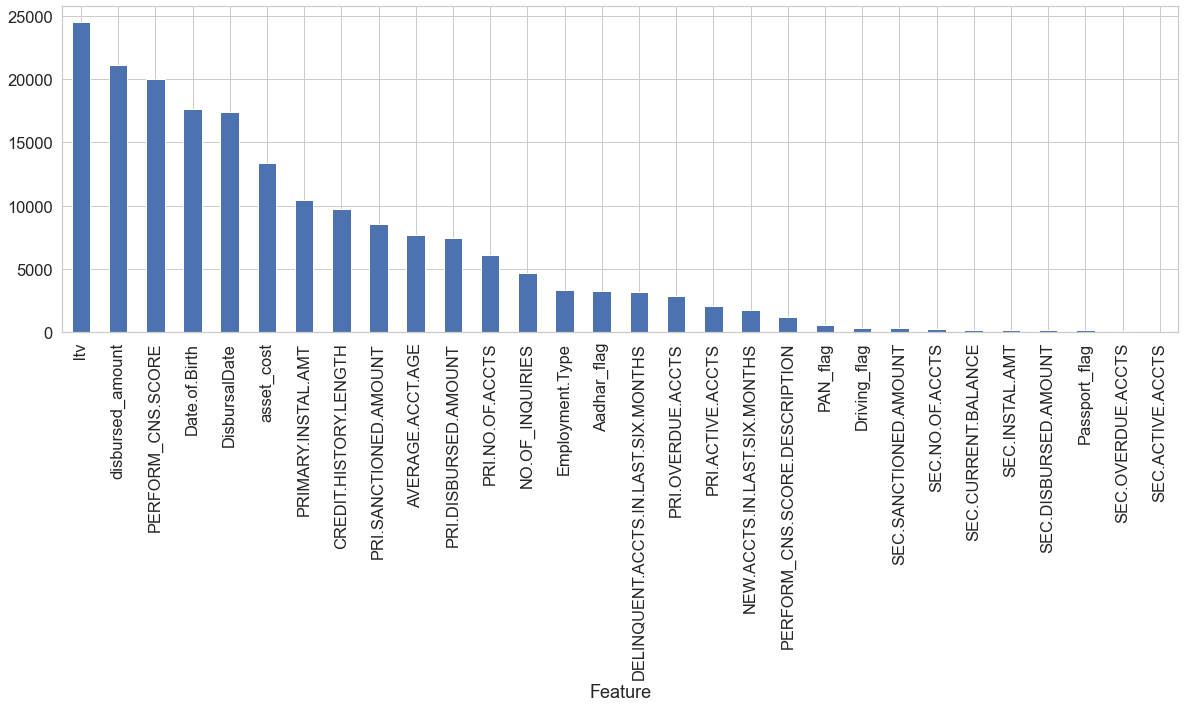

In [269]:
imps = automl_rd.model.get_feature_scores('fast')
imps.set_index('Feature')['Importance'].plot.bar(figsize=(20, 6))

In [270]:
imps.head(10)

,Feature,Importance
0,ltv,24514.055717
1,disbursed_amount,21066.907694
2,PERFORM_CNS.SCORE,20027.043957
3,Date.of.Birth,17636.558281
4,DisbursalDate,17380.054537
5,asset_cost,13405.197592
6,PRIMARY.INSTAL.AMT,10461.719209
7,CREDIT.HISTORY.LENGTH,9730.959504
8,PRI.SANCTIONED.AMOUNT,8524.043059
9,AVERAGE.ACCT.AGE,7671.993707


In [275]:
preds = automl.predict(x_test)

print(f'AUC score on train: {roc_auc_score(y_train.values, models.data[:, 0])}')
print(f'GINI score on train: {roc_auc_score(y_train.values, models.data[:, 0])*2-1}')
print()
print(f'AUC score on test: {roc_auc_score(y_test.values, preds.data[:, 0])}')
print(f'GINI score on test: {roc_auc_score(y_test.values, preds.data[:, 0])*2-1}')

AUC score on train: 0.6493588664101343
GINI score on train: 0.2987177328202686

AUC score on test: 0.6503250553387429
GINI score on test: 0.3006501106774857


# 3. Модели

In [10]:
# функция для оценки моделей
def get_report(pipe, x_test, y_test, pipe_grid=None, grid=False):
    
    predictions = pipe.predict(x_test)
    predictions = np.round(predictions.ravel(), 0)

    roc_auc_scores_pipe = roc_auc_score(y_test, pipe.predict_proba(x_test)[:, 1])
    gini = (2 * roc_auc_scores_pipe) - 1
    
    print(('y_test - ', Counter(y_test)))
    print(('predictions - ', Counter(predictions)))
    print()
    print(f'roc_auc_score - {round(roc_auc_scores_pipe, 4)}')
    print(('Gini - ', round(gini, 4)))
    
    if grid:
        roc_auc_scores_grid = roc_auc_score(y_test, pipe_grid.predict_proba(x_test)[:, 1])
        print(f'grid - pipe: {round(roc_auc_scores_grid - roc_auc_scores_pipe, 5)}')
        gini2 = (2 * roc_auc_scores_grid) - 1 - gini
        print(('Gini with grid - ', round(gini2, 4)))

    print()
    print((classification_report(y_test, predictions)))

In [11]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss, TomekLinks

In [12]:
%%time

data_clean=data_clean[columns_imp+['loan_default']]

y = data_clean.loan_default
x = data_clean.drop('loan_default', axis=1)

imbalance = SMOTETomek(sampling_strategy='minority', n_jobs=6)
x_imb, y_imb = imbalance.fit_resample(x, y)

x_imb.shape, y_imb.shape

CPU times: total: 6min 27s
Wall time: 1min 6s


((258774, 22), (258774,))

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_imb, y_imb, stratify=y_imb, test_size=0.25)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((194080, 22), (194080,), (64694, 22), (64694,))

## LogisticRegression

In [79]:
pipe_logreg = Pipeline(steps=[('sc', MinMaxScaler()), 
                       ('model', LogisticRegression(max_iter=1000, C=120, solver='lbfgs', tol=0.5))])

pipe_logreg.fit(x_train, y_train)

get_report(pipe=pipe_logreg, x_test=x_test, y_test=y_test)
print()

y_test -  Counter({1: 32347, 0: 32347})
predictions -  Counter({1: 36498, 0: 28196})

roc_auc_score - 0.6282
Gini -  0.2564

              precision    recall  f1-score   support

           0       0.61      0.53      0.56     32347
           1       0.58      0.66      0.62     32347

    accuracy                           0.59     64694
   macro avg       0.59      0.59      0.59     64694
weighted avg       0.59      0.59      0.59     64694




In [18]:
cv_pipe_logreg = cross_val_predict(pipe_logreg,
                                   cv=StratifiedKFold(n_splits=7, shuffle=True, random_state=42),
                                   X=x_train,
                                   y=y_train,
                                   verbose=1,
                                   n_jobs=-1,
                                   method='predict_proba')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    1.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    1.4s finished


In [19]:
print(f'auc score = {roc_auc_score(y_train, cv_pipe_logreg[:, 1]):.5f}')
print(f'Gini      = { (2 * roc_auc_score(y_train, cv_pipe_logreg[:, 1])) - 1 :.5f}')

auc score = 0.61076
Gini      = 0.22153


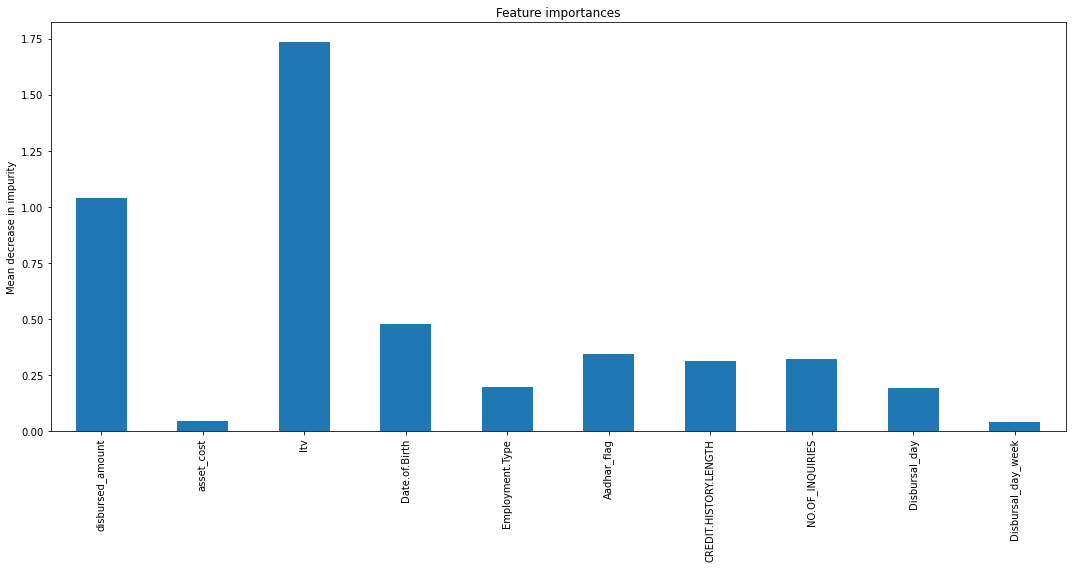

In [20]:
log_importances = pd.Series(abs(pipe_logreg[-1].coef_[0]), index=x_train.columns)

fig, ax = plt.subplots(figsize=(15,8))
log_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

In [21]:
pd.DataFrame(list(zip(pipe_logreg[-1].coef_[0], x.columns)), columns=['importance', 'features']) \
                                                    .set_index('features') \
                                                    .sort_values(by='importance', ascending=False)

,importance
features,
ltv,1.735552
disbursed_amount,1.038501
Date.of.Birth,0.479389
NO.OF_INQUIRIES,0.319072
Employment.Type,0.194984
Disbursal_day,0.190405
Disbursal_day_week,-0.042484
asset_cost,-0.045898
CREDIT.HISTORY.LENGTH,-0.312247


## LinearRegression

In [80]:
pipe_linreg = Pipeline(steps=[('scaler', MinMaxScaler()), 
                       ('logistic', LinearRegression(positive=True, fit_intercept=True))])

pipe_linreg.fit(x_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('logistic', LinearRegression(positive=True))])

In [54]:
predictions = pipe_linreg.predict(x_test)
diff = predictions - y_test

print(('MSE:', np.mean(diff**2)))
print(('MAE:', np.mean(abs(diff))))
print(('RMSE:', np.sqrt(np.mean(diff**2))))
print()
print((classification_report(y_test, np.round(predictions.ravel(), 0))))

MSE: 0.16682001425074902
MAE: 0.33374370591825975
RMSE: 0.40843605895017276

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     34176
           1       0.00      0.00      0.00      9573

    accuracy                           0.78     43749
   macro avg       0.39      0.50      0.44     43749
weighted avg       0.61      0.78      0.69     43749



In [173]:
pd.DataFrame(list(zip(pipe_linreg[-1].coef_, x.columns)), columns=['importance', 'features']) \
                                                    .set_index('features') \
                                                    .sort_values(by='importance', ascending=False)

,importance
features,
ltv,0.508396
asset_cost,0.182113
PERFORM_CNS.SCORE.DESCRIPTION,0.163587
Date.of.Birth,0.120533
PRI.OVERDUE.ACCTS,0.067084
Employment.Type,0.061530
DisbursalDate,0.055344
NO.OF_INQUIRIES,0.051976
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,0.045509


## RandomForestClassifier

In [14]:
pipe_rforest = Pipeline(steps=[
    ('sc', MinMaxScaler()), 
    ('m', RandomForestClassifier(verbose=1, 
                                 n_jobs=-1,
                                 criterion='gini',
                                 n_estimators=100))
])

pipe_rforest.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.9s finished


Pipeline(steps=[('sc', MinMaxScaler()),
                ('m', RandomForestClassifier(n_jobs=-1, verbose=1))])

In [178]:
get_report(pipe=pipe_rforest, x_test=x_test, y_test=y_test)
print()

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s


y_test -  Counter({0: 32516, 1: 32515})
predictions -  Counter({0: 34142, 1: 30889})

roc_auc_score - 0.9085
Gini -  0.8171

              precision    recall  f1-score   support

           0       0.82      0.86      0.84     32516
           1       0.85      0.81      0.83     32515

    accuracy                           0.83     65031
   macro avg       0.83      0.83      0.83     65031
weighted avg       0.83      0.83      0.83     65031




[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.4s finished


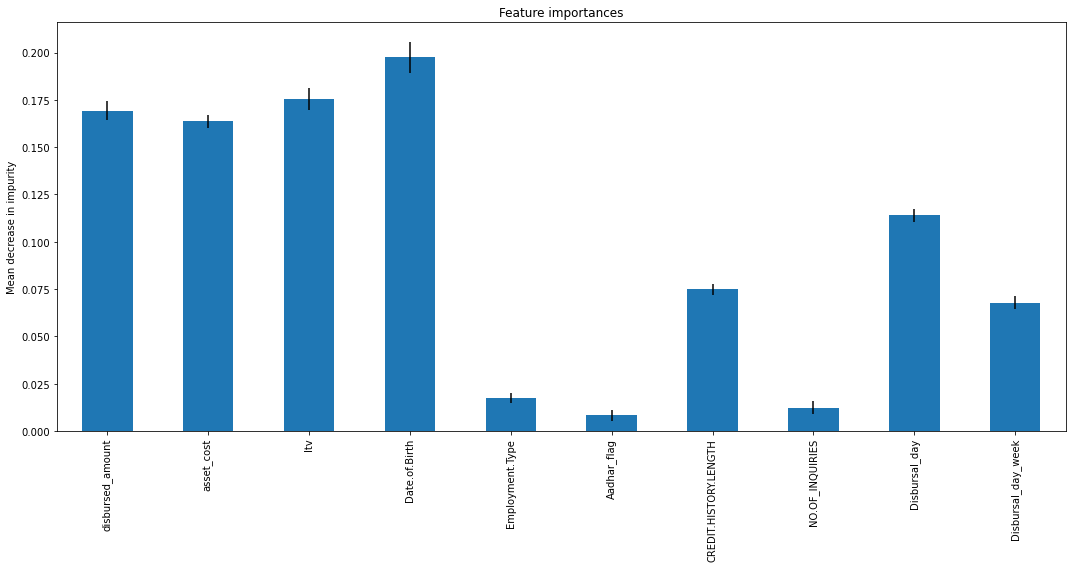

In [33]:
importances = pipe_rforest[-1].feature_importances_
std = np.std([tree.feature_importances_ for tree in pipe_rforest[-1].estimators_], axis=0)

forest_importances = pd.Series(importances, index=x_train.columns)

fig, ax = plt.subplots(figsize=(15,8))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

In [34]:
%%time
cv_pipe_rforest = cross_val_predict(pipe_rforest,
                                    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                    X=x_train,
                                    y=y_train,
                                    verbose=10,
                                    n_jobs=-1,
                                    method='predict_proba')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.6min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.6min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


CPU times: total: 156 ms
Wall time: 1min 34s


In [181]:
print(f'auc score = {roc_auc_score(y_train, cv_pipe_rforest[:, 1]):.5f}')
print(f'Gini      = { (2 * roc_auc_score(y_train, cv_pipe_rforest[:, 1]) - 1) :.5f}')

auc score = 0.89945
Gini      = 0.79891


## LGBMClassifier

In [16]:
pipe_lgbm_cls = Pipeline(steps=[('sc', MinMaxScaler()), 
                                ('model', LGBMClassifier(boosting_type='gbdt',
                                                         objective='binary' ,
                                                         n_estimators=1000,
                                                         max_depth=-1,
                                                         learning_rate=0.95,
                                                         num_leaves=70,
                                                         importance_type='gain'))])

pipe_lgbm_cls.fit(x_train, y_train)

Pipeline(steps=[('sc', MinMaxScaler()),
                ('model',
                 LGBMClassifier(importance_type='gain', learning_rate=0.95,
                                n_estimators=1000, num_leaves=70,
                                objective='binary'))])

In [17]:
get_report(pipe=pipe_lgbm_cls, x_test=x_test, y_test=y_test)
print()

y_test -  Counter({0: 32534, 1: 32534})
predictions -  Counter({0: 34847, 1: 30221})

roc_auc_score - 0.8822
Gini -  0.7645

              precision    recall  f1-score   support

           0       0.79      0.85      0.82     32534
           1       0.84      0.78      0.81     32534

    accuracy                           0.82     65068
   macro avg       0.82      0.82      0.82     65068
weighted avg       0.82      0.82      0.82     65068




In [18]:
pd.DataFrame(data=MinMaxScaler().fit_transform(pipe_lgbm_cls[-1].feature_importances_.reshape(-1, 1)), 
             index=x_imb.columns) \
             .sort_values(by=0, ascending=False)

,0
Date.of.Birth,1.000000
ltv,0.282073
disbursed_amount,0.198862
asset_cost,0.193115
Disbursal_day,0.180750
Disbursal_day_week,0.115186
PERFORM_CNS.SCORE.DESCRIPTION,0.088662
PRI.NO.OF.ACCTS,0.059265
PERFORM_CNS.SCORE,0.052126
PRIMARY.INSTAL.AMT,0.051009


In [21]:
%%time
cv_lgbm_cls = cross_val_predict(pipe_lgbm_cls,
                                    cv=StratifiedKFold(n_splits=5, shuffle=True),
                                    X=x_train,
                                    y=y_train,
                                    verbose=10,
                                    n_jobs=-1,
                                    method='predict_proba')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   18.7s remaining:   28.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   18.8s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.8s finished


CPU times: total: 78.1 ms
Wall time: 19.2 s


In [22]:
print(f'auc score = {roc_auc_score(y_train, cv_lgbm_cls[:, 1]):.5f}')
print(f'Gini      = { (2 * roc_auc_score(y_train, cv_lgbm_cls[:, 1]) - 1) :.5f}')

auc score = 0.88264
Gini      = 0.76527


## XGBClassifier

In [73]:
pipe_xgb_cls = Pipeline(steps=[('scaler', MinMaxScaler()), 
                               ('model', XGBClassifier(tree_method='gpu_hist',
                                                       objective='binary:logistic',
                                                       learning_rate=0.5,
                                                       n_estimators=50,
                                                       reg_lambda=25,
                                                       max_depth=30))])

pipe_xgb_cls.fit(x_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.5,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=30, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=50,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [189]:
get_report(pipe=pipe_xgb_cls, x_test=x_test, y_test=y_test)
print()

y_test -  Counter({0: 32516, 1: 32515})
predictions -  Counter({0: 41730, 1: 23301})

roc_auc_score - 0.8932
Gini -  0.7864

              precision    recall  f1-score   support

           0       0.77      0.99      0.87     32516
           1       0.99      0.71      0.82     32515

    accuracy                           0.85     65031
   macro avg       0.88      0.85      0.85     65031
weighted avg       0.88      0.85      0.85     65031




In [70]:
pd.DataFrame(data=MinMaxScaler().fit_transform(pipe_xgb_cls[-1].feature_importances_.reshape(-1, 1)), 
             index=x_imb.columns) \
             .sort_values(by=0, ascending=False)

,0
PERFORM_CNS.SCORE.DESCRIPTION,1.000000
Date.of.Birth,0.942232
PRI.ACTIVE.ACCTS,0.816047
PRI.NO.OF.ACCTS,0.401292
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,0.277978
NO.OF_INQUIRIES,0.241675
Disbursal_day_week,0.226205
Employment.Type,0.204117
NEW.ACCTS.IN.LAST.SIX.MONTHS,0.141666
PRI.OVERDUE.ACCTS,0.118445


In [71]:
%%time
cv_xgb_cls = cross_val_predict(pipe_xgb_cls,
                                    cv=StratifiedKFold(n_splits=5, shuffle=True),
                                    X=x_train,
                                    y=y_train,
                                    verbose=10,
                                    n_jobs=-1,
                                    method='predict_proba')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   36.4s remaining:   54.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   36.7s remaining:   24.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.8s finished


CPU times: total: 109 ms
Wall time: 39.2 s


In [192]:
print(f'auc score = {roc_auc_score(y_train, cv_xgb_cls[:, 1]):.5f}')
print(f'Gini      = { (2 * roc_auc_score(y_train, cv_xgb_cls[:, 1]) - 1) :.5f}')

auc score = 0.89322
Gini      = 0.78644


## CatBoost

In [74]:
from catboost import CatBoostClassifier, cv, Pool, MetricVisualizer
from catboost.utils import select_threshold, get_roc_curve, get_fpr_curve, get_fnr_curve
import sklearn.metrics
from sklearn.preprocessing import PolynomialFeatures

In [75]:
x_train_cat = MinMaxScaler().fit_transform(x_train)
x_test_cat = MinMaxScaler().fit_transform(x_test)

In [76]:
model_catboost_cls = CatBoostClassifier(
    loss_function='Logloss', custom_loss='AUC', #eval_metric='AUC',
    learning_rate=0.01, iterations=5000,
#     l2_leaf_reg=7, random_strength=10, bagging_temperature=7
    l2_leaf_reg=10, random_strength=101, bagging_temperature=5, depth=8,
)

m = model_catboost_cls.fit(x_train_cat, y_train, eval_set=(x_test_cat, y_test),
                       verbose=500, plot=True, early_stopping_rounds=200)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6929363	test: 0.6929322	best: 0.6929322 (0)	total: 185ms	remaining: 15m 27s
500:	learn: 0.6326113	test: 0.6350063	best: 0.6350063 (500)	total: 15.5s	remaining: 2m 19s
1000:	learn: 0.6117366	test: 0.6162914	best: 0.6162914 (1000)	total: 30.7s	remaining: 2m 2s
1500:	learn: 0.5711629	test: 0.5771297	best: 0.5771297 (1500)	total: 46.1s	remaining: 1m 47s
2000:	learn: 0.3996806	test: 0.4062846	best: 0.4062846 (2000)	total: 1m 1s	remaining: 1m 32s
2500:	learn: 0.3521072	test: 0.3602732	best: 0.3602732 (2500)	total: 1m 17s	remaining: 1m 17s
3000:	learn: 0.3405431	test: 0.3515979	best: 0.3515979 (3000)	total: 1m 33s	remaining: 1m 2s
3500:	learn: 0.3332544	test: 0.3471727	best: 0.3471727 (3500)	total: 1m 50s	remaining: 47.2s
4000:	learn: 0.3277060	test: 0.3443081	best: 0.3443076 (3999)	total: 2m 6s	remaining: 31.6s
4500:	learn: 0.3229892	test: 0.3421905	best: 0.3421905 (4500)	total: 2m 23s	remaining: 15.9s
4999:	learn: 0.3195581	test: 0.3414116	best: 0.3414116 (4999)	total: 2m 41s	re

In [77]:
print(f'auc score = {roc_auc_score(y_test, model_catboost_cls.predict_proba(x_test_cat)[:, 1]):.5f}')
print(f'Gini      = { (2 * roc_auc_score(y_test, model_catboost_cls.predict_proba(x_test_cat)[:, 1]) - 1) :.5f}')

auc score = 0.89838
Gini      = 0.79675


## NN

In [ ]:
columns_imp=['disbursed_amount',
 'asset_cost',
 'ltv',
 'PERFORM_CNS.SCORE',
 'PERFORM_CNS.SCORE.DESCRIPTION',
 'Disbursal_day_week']

# нормируем данные
for ind, val in enumerate(data_clean[columns_imp]):
    data_clean[val] = np.log1p(data_clean[val])

In [ ]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss, TomekLinks

data_clean=data_clean[columns_imp+['loan_default']]

y = data_clean.loan_default
x = data_clean.drop('loan_default', axis=1)

In [68]:
%%time

imbalance = SMOTETomek(sampling_strategy='minority', n_jobs=-1)
x_imb, y_imb = imbalance.fit_resample(x, y)

x_imb.shape, y_imb.shape

CPU times: user 9.75 s, sys: 17.4 ms, total: 9.77 s
Wall time: 7.91 s


((250112, 6), (250112,))

In [69]:
x_train, x_test, y_train, y_test = train_test_split(x_imb, y_imb, stratify=y_imb, test_size=0.2)

x_train_sc = MinMaxScaler().fit_transform(x_train)
x_test_sc = MinMaxScaler().fit_transform(x_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((200089, 6), (200089,), (50023, 6), (50023,))

In [ ]:
model = Sequential()

model.add(Dense(units = 300, input_shape = (x_train_sc.shape[1],), activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(Dense(200, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

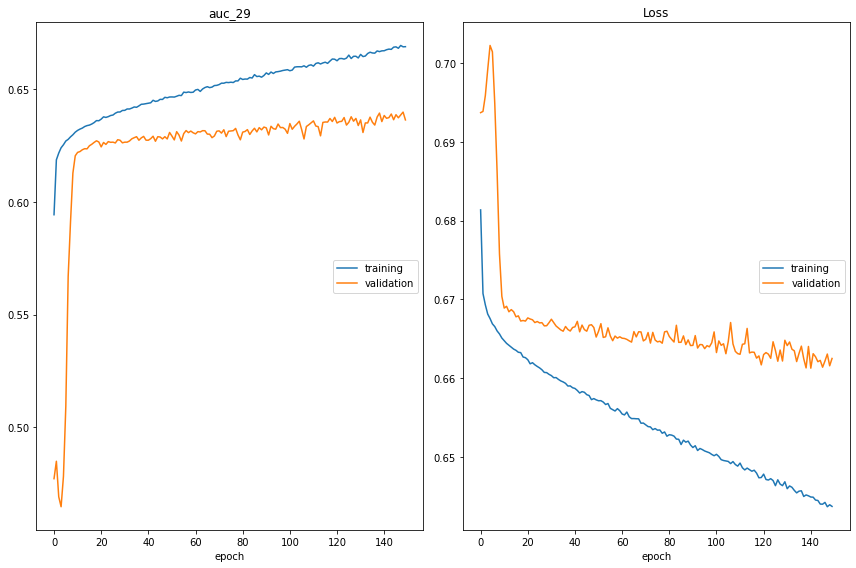

auc_29
	training         	 (min:    0.594, max:    0.669, cur:    0.669)
	validation       	 (min:    0.465, max:    0.640, cur:    0.636)
Loss
	training         	 (min:    0.644, max:    0.681, cur:    0.644)
	validation       	 (min:    0.661, max:    0.702, cur:    0.662)
74/74 [==============================] - 1s 14ms/step - loss: 0.6437 - auc_29: 0.6689 - val_loss: 0.6625 - val_auc_29: 0.6364



In [87]:
cp = ModelCheckpoint('model/', save_best_only=True)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=0.0008, nesterov=True), 
# metrics=[keras.metrics.AUC()])

model.compile(loss=keras.losses.BinaryCrossentropy(), 
              optimizer=keras.optimizers.Adam(learning_rate=0.00005), 
              metrics=[keras.metrics.AUC()]
              )

history = model.fit(x_train_sc, 
                    y_train, 
                    validation_split=0.25, 
                    batch_size=2048, 
                    epochs=150, 
                    verbose=1,
                    callbacks=[cp, 
                               PlotLossesKeras(), 
                               callback])
                                 

print('\n ==============')

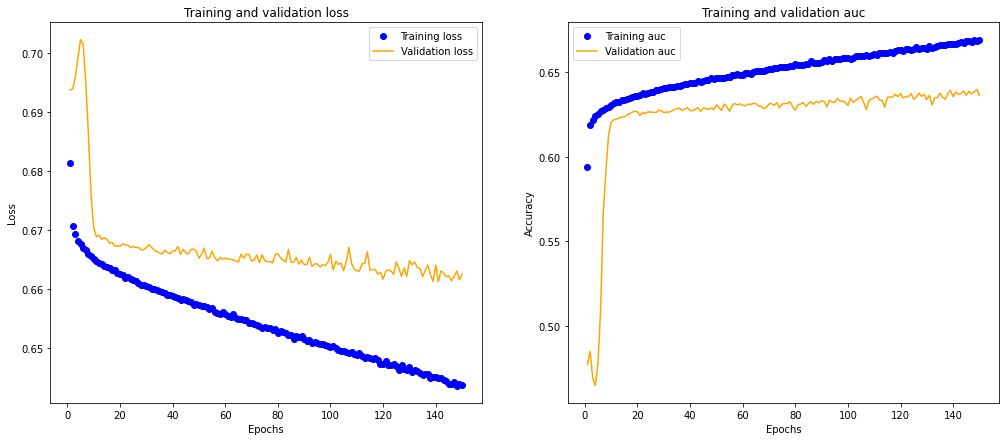


Best auc score: 0.6399089694023132


In [88]:
plt.figure(figsize=(17, 7))
plt.subplot(1, 2, 1)

loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

epochs = range(1, len(loss_values) + 1) 

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
acc = history.history[list(history.history.keys())[1]]
val_acc = history.history[list(history.history.keys())[3]]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training auc')
plt.plot(epochs, val_acc, 'orange', label='Validation auc')
plt.title('Training and validation auc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print()
print(f'Best auc score: {np.max(val_acc)}')

plt.show()

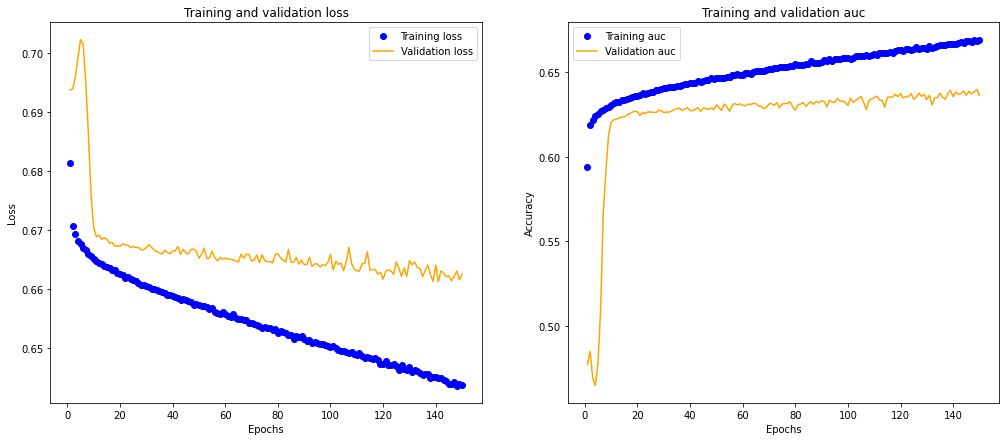


Best auc score: 0.6399089694023132


In [88]:
plt.figure(figsize=(17, 7))
plt.subplot(1, 2, 1)

loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

epochs = range(1, len(loss_values) + 1) 

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
acc = history.history[list(history.history.keys())[1]]
val_acc = history.history[list(history.history.keys())[3]]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training auc')
plt.plot(epochs, val_acc, 'orange', label='Validation auc')
plt.title('Training and validation auc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print()
print(f'Best auc score: {np.max(val_acc)}')

plt.show()

In [89]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, auc, roc_curve

model = load_model('model/')

predictions = model.predict(x_test_sc, batch_size=128)
predictions = np.round(predictions.ravel(), 0)

print()
print('auc(fpr, tpr)', auc(roc_curve(y_test, predictions)[0], roc_curve(y_test, predictions)[1]))
print()
print(classification_report(y_test, predictions))
print()
print('test loss, test acc:', model.evaluate(x_test_sc, y_test, batch_size=256))

391/391 [==============================] - 3s 6ms/step

auc(fpr, tpr) 0.5920484903482385

              precision    recall  f1-score   support

           0       0.60      0.55      0.57     25012
           1       0.58      0.63      0.61     25011

    accuracy                           0.59     50023
   macro avg       0.59      0.59      0.59     50023
weighted avg       0.59      0.59      0.59     50023


196/196 [==============================] - 1s 4ms/step - loss: 0.6674 - auc_29: 0.6253
test loss, test acc: [0.6674125790596008, 0.6252862215042114]


# Результаты

In [101]:
da = [['LogisticRegression',
       roc_auc_score(y_test, pipe_logreg.predict_proba(x_test)[:, 1]),
       2 * roc_auc_score(y_test, pipe_logreg.predict_proba(x_test)[:, 1])-1,
       precision_recall_fscore_support(y_test, np.round(pipe_logreg.predict(x_test), 0), average='weighted')[0],
       precision_recall_fscore_support(y_test, np.round(pipe_logreg.predict(x_test), 0), average='weighted')[1],
       precision_recall_fscore_support(y_test, np.round(pipe_logreg.predict(x_test), 0), average='weighted')[2]],
      
      ['LinearRegression',
       0,
       0,
       precision_recall_fscore_support(y_test, np.round(pipe_linreg.predict(x_test), 0), average='weighted')[0],
       precision_recall_fscore_support(y_test, np.round(pipe_linreg.predict(x_test), 0), average='weighted')[1],
       precision_recall_fscore_support(y_test, np.round(pipe_linreg.predict(x_test), 0), average='weighted')[2]],
      
      ['RandomForestClassifier',
       roc_auc_score(y_test, pipe_rforest.predict_proba(x_test)[:, 1]),
       2 * roc_auc_score(y_test, pipe_rforest.predict_proba(x_test)[:, 1])-1,
       precision_recall_fscore_support(y_test, np.round(pipe_rforest.predict(x_test), 0), average='weighted')[0],
       precision_recall_fscore_support(y_test, np.round(pipe_rforest.predict(x_test), 0), average='weighted')[1],
       precision_recall_fscore_support(y_test, np.round(pipe_rforest.predict(x_test), 0), average='weighted')[2]],
      
      ['LGBMClassifier',
       roc_auc_score(y_test, pipe_lgbm_cls.predict_proba(x_test)[:, 1]),
       2 * roc_auc_score(y_test, pipe_lgbm_cls.predict_proba(x_test)[:, 1])-1,
       precision_recall_fscore_support(y_test, np.round(pipe_lgbm_cls.predict(x_test), 0), average='weighted')[0],
       precision_recall_fscore_support(y_test, np.round(pipe_lgbm_cls.predict(x_test), 0), average='weighted')[1],
       precision_recall_fscore_support(y_test, np.round(pipe_lgbm_cls.predict(x_test), 0), average='weighted')[2]],
      
      ['XGBClassifier',
       roc_auc_score(y_test, pipe_xgb_cls.predict_proba(x_test)[:, 1]),
       2 * roc_auc_score(y_test, pipe_xgb_cls.predict_proba(x_test)[:, 1])-1,
       precision_recall_fscore_support(y_test, np.round(pipe_xgb_cls.predict(x_test), 0), average='weighted')[0],
       precision_recall_fscore_support(y_test, np.round(pipe_xgb_cls.predict(x_test), 0), average='weighted')[1],
       precision_recall_fscore_support(y_test, np.round(pipe_xgb_cls.predict(x_test), 0), average='weighted')[2]],
 
      ['CatBoostClassifier',
       roc_auc_score(y_test, model_catboost_cls.predict_proba(x_test_cat)[:, 1]),
       2 * roc_auc_score(y_test, model_catboost_cls.predict_proba(x_test_cat)[:, 1])-1,
       precision_recall_fscore_support(y_test, np.round(model_catboost_cls.predict(x_test_cat), 0), average='weighted')[0],
       precision_recall_fscore_support(y_test, np.round(model_catboost_cls.predict(x_test_cat), 0), average='weighted')[1],
       precision_recall_fscore_support(y_test, np.round(model_catboost_cls.predict(x_test_cat), 0), average='weighted')[2]],

      ['NN',
       0.6252862215042114,
       2 * 0.6252862215042114 - 1,
       0.59,
       0.59,
       0.59]
      
     ]

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_job

In [108]:
result = pd.DataFrame(da, columns=['Model', 'AUC', 'GINI', 'PRECISION', 'RECALL', 'FSCORE']).set_index('Model')

result.sort_values(by='GINI', ascending=False)\
.style.background_gradient(cmap=sns.light_palette('darkblue', as_cmap=True), vmin=0.762)

,AUC,GINI,PRECISION,RECALL,FSCORE
Model,,,,,
RandomForestClassifier,0.907231,0.814462,0.830873,0.830123,0.830027
CatBoostClassifier,0.898376,0.796751,0.883272,0.851331,0.848168
XGBClassifier,0.892632,0.785265,0.834506,0.825981,0.824865
LGBMClassifier,0.881125,0.762250,0.819630,0.817216,0.816871
NN,0.755713,0.511426,0.780000,0.800000,0.770000
LogisticRegression,0.628177,0.256354,0.593889,0.592342,0.590657
LinearRegression,0.000000,0.000000,0.586893,0.585247,0.583274
